# Imports

In [18]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import shap
from src.config import CONFIG
from src.data_processing import DataProcessor
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_validate

# Load and process data

In [19]:
dp = DataProcessor()
data = dp.process_data(CONFIG.DATA_PATH)

cat_cols = dp.CAT_COLS.copy()
num_cols = dp.NUM_COLS.copy()

# Model development

### Train/Test split

Como hay solo 10_000 samples, dejo 1500 para test

In [29]:
X = data.drop(columns=[CONFIG.TARGET])
y = data[CONFIG.TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=CONFIG.SEED, stratify=y)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (8500, 18), Test size: (1500, 18)


In [34]:
lgb_params = {
                    'objective': 'binary',
                    'verbosity': -1,
                    # 'n_estimators': 100,
                    'boosting_type': 'gbdt',
                    'random_state': CONFIG.SEED,
                    }


lgb_model = LGBMClassifier(**lgb_params)

### K-Fold Cross-Validation

In [35]:
# Cross-validation setup
scoring = {'accuracy': 'accuracy', 'roc_auc': 'roc_auc'}

cv_results = cross_validate(
    lgb_model, X_train, y_train, 
    cv=CONFIG.N_FOLDS, 
    scoring=scoring, 
    return_train_score=True
)

# Display results
print("Cross-validation results:\n")
print(f"  Train Accuracy: {np.mean(cv_results['train_accuracy']):.4f}")
print(f"  Train ROC AUC: {np.mean(cv_results['train_roc_auc']):.4f}")
print(f"  Cross-validation Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"  Cross-validation AUC: {np.mean(cv_results['test_roc_auc']):.4f}")

Cross-validation results:

  Train Accuracy: 1.0000
  Train ROC AUC: 1.0000
  Cross-validation Accuracy: 0.9988
  Cross-validation AUC: 1.0000



Test Accuracy: 0.9987
Test AUC: 1.0000


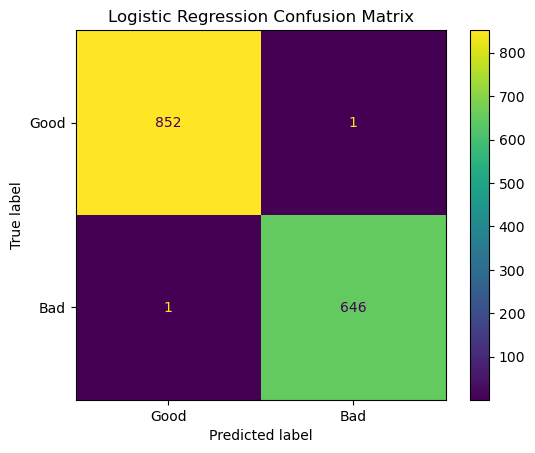

In [36]:
lgb_model.fit(X_train, y_train)

y_test_pred = lgb_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, lgb_model.predict_proba(X_test)[:, 1])

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Good', 'Bad']);
plt.title('Logistic Regression Confusion Matrix')
plt.savefig(os.path.join(CONFIG.RESULTS_DIR, 'lgb_confusion_matrix.png'), dpi=120)

/home/ezemriv/anaconda3/envs/ds_312/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


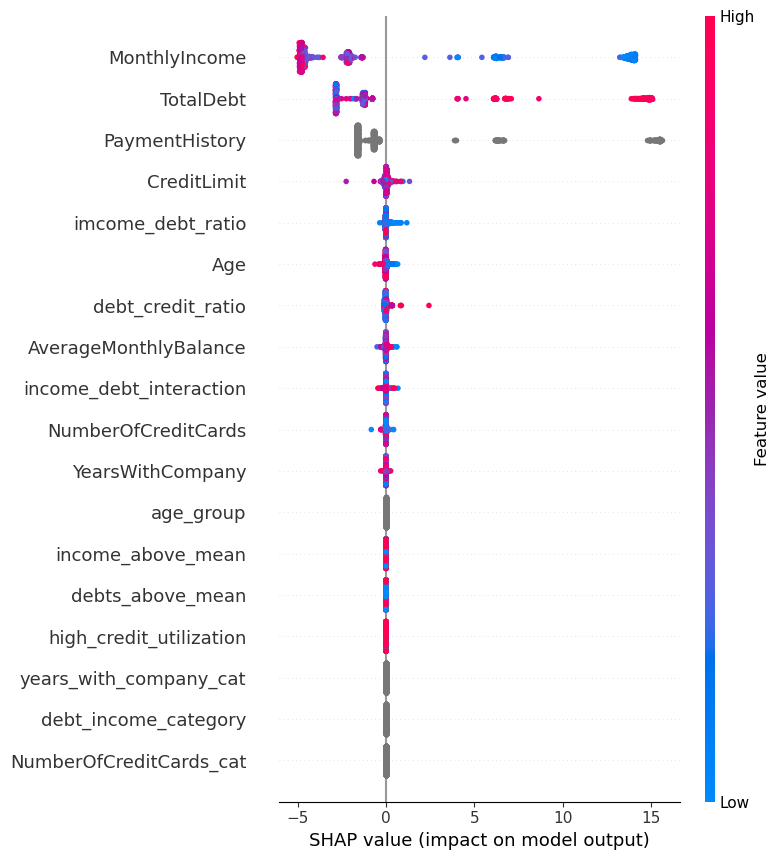

In [37]:
# Use TreeExplainer for LightGBM model
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, show=False)
plt.savefig(os.path.join(CONFIG.RESULTS_DIR, 'lgb_shap_summary.png'), dpi=120)